<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Project/CINN_for_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.transforms.functional import to_tensor


from scipy.stats import special_ortho_group
from sklearn.datasets import make_moons, load_digits
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.pyplot as plt
import math

### Let's now load the saved AE model and begin creating the dataset for the CINN training:

In [2]:
device=  "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
class Autoencoder_simpler(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(Autoencoder_simpler, self).__init__()

        self.dropout_prob = dropout_prob

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_conv2 = nn.Conv2d(16, 24, kernel_size=3, stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_linear = nn.Linear(24 * 7 * 7, 24)  # 64*6 ---> 20

        # Dropout layers
        self.dropout = nn.Dropout(p=self.dropout_prob)  # Add dropout layer

        # Decoder layers
        self.decoder_linear = nn.Linear(24, 24* 7 * 7)
        self.decoder_conv1 = nn.ConvTranspose2d(24, 16, kernel_size=3, stride=2, padding=1, output_padding=1)  # Use stride 2 for upscaling
        self.decoder_conv2 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)  # Use stride 2 for upscaling

    def encoder(self, x):
    # Encoder
        x = self.encoder_conv1(x)
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.encoder_conv2(x)
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = x.reshape(-1, 24 * 7 * 7)  # Use .reshape() instead of .view()
        x = self.encoder_linear(x)
        return x

    def decoder(self, x):
        # Decoder
        x = self.decoder_linear(x)
        x = x.view(-1, 24, 7, 7)
        x = self.decoder_conv1(x)
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.decoder_conv2(x)
        x = torch.relu(x)
        x = torch.clamp(x, 0, 1) # Clamp output
        return x

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
# Define the path to the pretrained model
checkpoint_path = "/content/autoencoder_mixed_mnist_dropout_0.01_60_epochs.pth"

# Load the pretrained model
pretrained_model_list = torch.load(checkpoint_path,map_location=torch.device('cpu'))

ae_model=Autoencoder_simpler(dropout_prob=0.01)
ae_model.to(device)

ae_model.load_state_dict(pretrained_model_list)

<All keys matched successfully>

### Let's load the dataset here:

In [5]:
encoded_image_train_set=torch.load("/content/encoded_images_train_set.pt")
encoded_image_train_set=encoded_image_train_set[30000:90000,:]
encoded_image_test_set= torch.load("/content/encoded_images_test_set.pt")

In [6]:
### 0 for uncolored and 1 for colored
len_train=encoded_image_train_set.size()[0]
len_test=encoded_image_test_set.size()[0]

labels_train= torch.cat((torch.zeros(len_train // 2),torch.ones(len_train // 2)))
labels_test = torch.cat((torch.zeros(len_test // 2),torch.ones(len_test // 2)))

In [7]:
encoded_image_train_set.size(), labels_train.size(), encoded_image_test_set.size(), labels_test.size()

(torch.Size([60000, 24]),
 torch.Size([60000]),
 torch.Size([20000, 24]),
 torch.Size([20000]))

### Creating the dataloader

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Assuming you have a CustomDataset class defined
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.color_labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.color_labels[idx]

# Assuming you have the train_dataset
train_dataset = CustomDataset(encoded_image_train_set, labels_train)
test_dataset = CustomDataset(encoded_image_test_set, labels_test)

# Calculate the number of samples for training and validation
total_samples = len(train_dataset)
train_size = int(0.9 * total_samples)
val_size = total_samples - train_size

# Split the train_dataset into train and val datasets with a fixed random seed
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size],
                                          generator=torch.Generator().manual_seed(42))

# Define batch size
batch_size = 32

# Create data loaders for train, val, and test sets with shuffling and fixed random seed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          worker_init_fn=np.random.seed)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### CINN code:

In [10]:
def subnet_constructor(input_size, hidden_size, output_size):
    model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
    )
    return model

def ortogonal_matrix(dim):
    """
    A = torch.normal(mean=torch.zeros((dim,dim)), std=torch.ones((dim,dim)))
    Q, _ = torch.linalg.qr(A)
    if dim == 2:
        Q[1,1] = -Q[0,0]
        Q[0,1] = -Q[1,0]
        print(torch.linalg.det(Q))
    return Q
    """
    Q = special_ortho_group.rvs(dim)
    return torch.Tensor(Q)



In [11]:
class conditional_coupling_block(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size
        self.split1 = math.floor(self.input_size/2)
        self.split2 = self.input_size - self.split1
        self.subnet = subnet_constructor(self.split1 + self.condition_size, self.hidden_size, 2*self.split2)

    def forward(self, x, cond, rev=False):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]
        params = self.subnet(torch.cat([x1, cond], -1))
        s, t = params[...,:self.split2], params[...,self.split2:]
        s = torch.tanh(s)
        ljd = torch.sum(s, -1)

        if not rev:
            s = torch.exp(s)
            x2 = s*x2 + t
            return torch.cat([x1,x2], -1), ljd

        if rev:
            s = torch.exp(-s)
            x2 = s * (x2-t)
            return torch.cat([x1,x2], -1)



In [12]:
class conditional_realNVP(nn.Module):
    def __init__(self, input_size, hidden_size, n_blocks, condition_size,
                 device='cuda' if torch.cuda.is_available() else 'cpu'):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_blocks = n_blocks
        self.condition_size = condition_size
        self.device = device

        # Move conditional_coupling_blocks to specified device
        self.coupling_blocks = nn.ModuleList([
            conditional_coupling_block(input_size, hidden_size, self.condition_size).to(device)
            for _ in range(n_blocks)
        ])

        self.orthogonal_matrices = [ortogonal_matrix(input_size).to(device)
        for _ in range(n_blocks-1)]


    def forward(self, x, cond, rev=False):
        if rev:
            return self._inverse(x, cond)
        return self._forward(x, cond)

    def _forward(self, x, cond):
        cond = nn.functional.one_hot(cond.to(torch.int64), num_classes=self.condition_size)
        ljd = torch.zeros((x.shape[0])).to(device)
        for l in range(self.n_blocks-1):
            x, partial_ljd = self.coupling_blocks[l](x, cond)
            ljd += partial_ljd
            x = torch.matmul(x, self.orthogonal_matrices[l])
        x, partial_ljd = self.coupling_blocks[-1](x, cond)
        ljd += partial_ljd
        return x, ljd

    def _inverse(self, x, cond):
        cond = nn.functional.one_hot(cond.to(torch.int64), num_classes=self.condition_size)
        for l in range(self.n_blocks-1, 0, -1):
            x = self.coupling_blocks[l](x, cond, rev=True)
            x = torch.matmul(x, self.orthogonal_matrices[l-1].T)
        x = self.coupling_blocks[0](x, cond, rev=True)
        return x

    def sample(self, num_samples, cond=None):
        samples = []
        if cond is None:
            for c in range(self.condition_size):
                z = torch.normal(mean=torch.zeros((num_samples, self.input_size)), std=torch.ones((num_samples, self.input_size)))
                samples.append(self._inverse(z, cond=c*torch.ones(num_samples)))
        else:
            z = torch.normal(mean=torch.zeros((num_samples, self.input_size)), std=torch.ones((num_samples, self.input_size)))
            samples.append(self._inverse(z, cond=cond*torch.ones(num_samples)))
        return torch.cat(samples, 0)


In [13]:
# train and evaluate function
def train_and_evaluate_cinn(model, train_loader, val_loader, device,
                       num_epochs=10, learning_rate=1e-3, weight_decay=0.001,
                       step_size_scheduler=5,gamma_scheduler=0.5,
                       print_epoch=10, ):


    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=step_size_scheduler,
                                          gamma= gamma_scheduler)  # Learning rate scheduler

    model.to(device)  # Move model to device

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        train_loss = 0.0
        val_loss = 0.0

        # Training
        model.train()
        for data in train_loader:
            x_data, y_data = data[0], data[1] # extract the data
            x_data, y_data = x_data.to(device), y_data.to(device)

            batch_size = x_data.size(0)  # Get actual batch size


            optimizer.zero_grad()
            z, ljd = model(x_data, y_data)

            loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batch_size
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
            for data in val_loader:
                x_data, y_data = data[0], data[1] # extract the data
                x_data, y_data = x_data.to(device), y_data.to(device)
                batch_size = x_data.size(0)  # Get actual batch size

                z, ljd = model(x_data, y_data)
                loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batch_size

                val_loss += loss.item()

        # Average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Step the learning rate scheduler
        scheduler.step()

        # Print losses
        if (epoch + 1) % print_epoch == 0:
            print(f"\nEpoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.9f}, Val Loss: {val_loss:.9f}")

    return train_losses, val_losses


In [14]:
def plot_train_and_val_losses(train_losses, val_losses):
    plt.figure(figsize=(7, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

Let's try to train CINN on our dataset so that we can proceed with the task of style transfer:

In [15]:
# let's instantiate the model
model_cinn_style_transfer= conditional_realNVP(input_size=24, hidden_size=20,n_blocks=4
                                               , condition_size=2)
# model_cinn_style_transfer.to(device)
# model_cinn_style_transfer

In [16]:
args_dict = {
    'model': model_cinn_style_transfer,
    'train_loader': train_loader,
    'val_loader': val_loader,
    'num_epochs': 10,
    'learning_rate': 1e-3,
    'weight_decay': 0.001,
    'step_size_scheduler': 100,
    'gamma_scheduler': 0.5,
    'print_epoch': 2,
    'device': device
}


In [17]:
# let's train and evaluate
train_loss, val_loss = train_and_evaluate_cinn(**args_dict)

Epochs:  20%|██        | 2/10 [03:01<12:04, 90.54s/it]


Epoch [2/10], Train Loss: 1.938112488, Val Loss: 1.372415659


Epochs:  40%|████      | 4/10 [06:01<09:01, 90.17s/it]


Epoch [4/10], Train Loss: 0.587171092, Val Loss: 0.424277066


Epochs:  60%|██████    | 6/10 [09:04<06:04, 91.22s/it]


Epoch [6/10], Train Loss: 0.059633343, Val Loss: -0.111467391


Epochs:  80%|████████  | 8/10 [12:07<03:02, 91.11s/it]


Epoch [8/10], Train Loss: -0.234652408, Val Loss: -0.324660342


Epochs: 100%|██████████| 10/10 [15:14<00:00, 91.43s/it]


Epoch [10/10], Train Loss: -0.428850856, Val Loss: -0.478662648


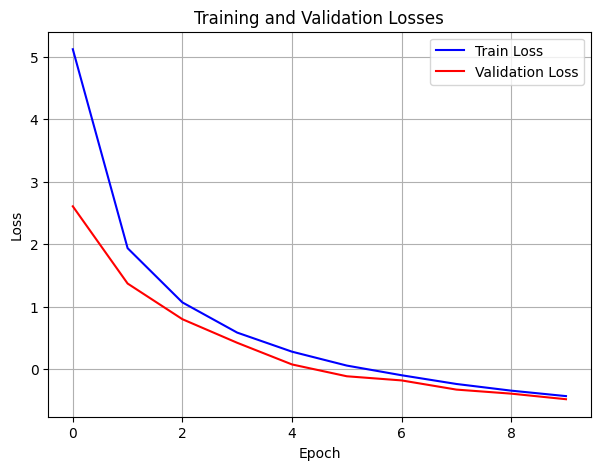

In [18]:
plot_train_and_val_losses(train_loss, val_loss)

### let's attempt style transfer

In [24]:
def style_transfer_after_training(model_cinn, encoded_source_image, source_style_label,
                                  label_target_style, device=device):
    encoded_source_image, source_style_label = encoded_source_image.to(device), source_style_label.to(device)


    # Get the residual
    model_cinn.eval()
    z, _ = model_cinn( encoded_source_image, source_style_label)

    # Define the target style label
    y_label_colored = torch.tensor([label_target_style]).to(device)

    # Transfer the style
    model_cinn.eval()
    x_transfered = model_cinn._inverse(z, y_label_colored[0])

    return x_transfered

def decode_latent_vec(latent_rep, ae_model):
  ae_model.eval()
  decoded= ae_model.decoder(latent_rep)
  return decoded


In [35]:
i=68
x_uncolored, y_label=encoded_image_test_set[i,:], labels_test[i]
x_uncolored, y_label= x_uncolored.to(device), y_label.to(device)
x_trans_check= style_transfer_after_training(model_cinn_style_transfer,
                                             x_uncolored, y_label, 1, device=device)

### let's send x through the decoder
decoded_x_style_trans= decode_latent_vec(x_trans_check, ae_model)
decoded_original= decode_latent_vec(x_uncolored, ae_model)
print(decoded_x_style_trans.shape);print(decoded_original.shape)

torch.Size([1, 3, 28, 28])
torch.Size([1, 3, 28, 28])


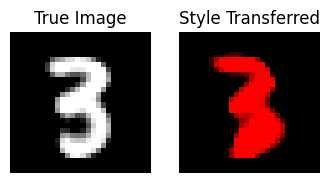

In [36]:
def plot_images(image1, image2):
    fig, axes = plt.subplots(1, 2,figsize=(4, 4))
    axes[0].imshow(np.transpose(image1.squeeze().detach().cpu().numpy(), (1, 2, 0)))  # Transpose image dimensions from (1, 3, 28, 28) to (28, 28, 3)
    axes[0].set_title('True Image')
    axes[0].axis('off')

    axes[1].imshow(np.transpose(image2.squeeze().detach().cpu().numpy(), (1, 2, 0)))  # Transpose image dimensions from (1, 3, 28, 28) to (28, 28, 3)
    axes[1].set_title('Style Transferred')
    axes[1].axis('off')

    plt.show()

plot_images(decoded_original, decoded_x_style_trans)

few more datasets:

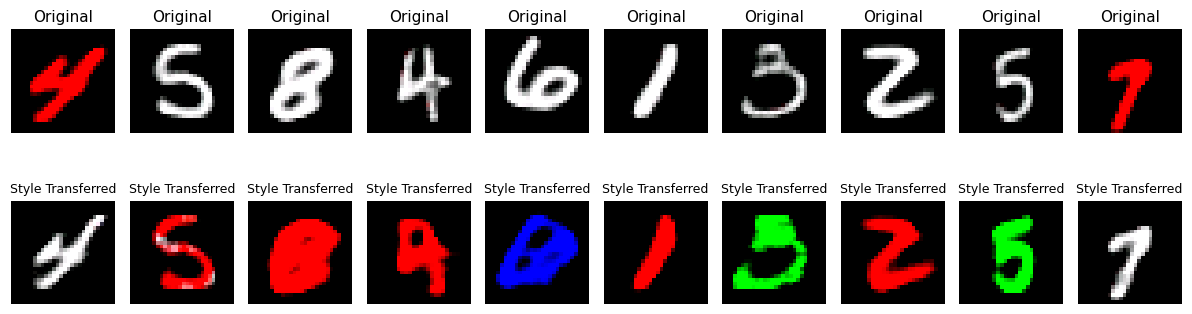

In [37]:
import random
import matplotlib.pyplot as plt

# Define a function to plot multiple images in a subplot
def plot_images_subplot(images, titles):
    fig, axes = plt.subplots(2, 10, figsize=(12, 4))

    for i, (original, style_transferred) in enumerate(images):
        # Plot original images in the first row
        axes[0, i].imshow(original.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
        axes[0, i].set_title(titles[i][0], fontsize=11)
        axes[0, i].axis('off')

        # Plot style transferred images in the second row
        axes[1, i].imshow(style_transferred.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
        axes[1, i].set_title(titles[i][1], fontsize=9)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()


# Select 5 random indices from the test set
random_indices = random.sample(range(len(encoded_image_test_set)), 10)

# Perform style transfer and plot for each selected image
images_to_plot = []
titles = []

for i in random_indices:
    x_uncolored, y_label = encoded_image_test_set[i], labels_test[i]
    x_uncolored, y_label= x_uncolored.to(device), y_label.to(device)
    source_style_label = 0 if y_label == 1 else 1
    label_target_style = 1 if y_label == 0 else 0

    x_trans_check = style_transfer_after_training(model_cinn_style_transfer,
                                                  x_uncolored, y_label, label_target_style, device=device)

    decoded_original = decode_latent_vec(x_uncolored, ae_model)
    decoded_x_style_trans = decode_latent_vec(x_trans_check, ae_model)

    images_to_plot.append((decoded_original, decoded_x_style_trans))
    titles.append(('Original', 'Style Transferred'))

# Plot the original and style transferred images in a subplot
plot_images_subplot(images_to_plot, titles)


## Although the code below is not relevant anymore, for the time being don't delete it

### Dataset for style transfer with CINN:

In [ ]:
# Function to randomly colorize MNIST dataset with a single color channel
# def random_colorize_rgb_mnist(X):
#     colored_X = np.zeros((X.shape[0], X.shape[1], X.shape[2], 3), dtype=np.uint8)

#     for i in range(X.shape[0]):
#         img = X[i]

#         # Generate random color channel index (0 for red, 1 for green, 2 for blue)
#         color_channel_index = np.random.randint(0, 3)

#         # Set the color based on the selected color channel
#         color = [0, 0, 0]
#         color[color_channel_index] = 255

#         # Colorize the digits while keeping the background unchanged
#         colored_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
#         colored_img[img > 0] = color
#         colored_X[i] = colored_img

#     return colored_X

In [ ]:
### Load MNIST training dataset
# train_dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
# uncolored_X_train = train_dataset.data.numpy()
# uncolored_y_train = train_dataset.targets.numpy()

# ### Load MNIST test dataset
# test_dataset = MNIST(root='./data', train=False, download=True, transform=ToTensor())
# uncolored_X_test = test_dataset.data.numpy()
# uncolored_y_test = test_dataset.targets.numpy()


# colored_rgb_X_train = random_colorize_rgb_mnist(uncolored_X_train)
# colored_rgb_X_test = random_colorize_rgb_mnist(uncolored_X_test)

# ### labels for the dataset
# # Create labels for uncolored datasets
# uncolored_labels_train = np.zeros(len(uncolored_X_train))
# uncolored_labels_test = np.zeros(len(uncolored_X_test))

# # Create labels for colored datasets
# colored_labels_train = np.ones(len(colored_rgb_X_train))
# colored_labels_test = np.ones(len(colored_rgb_X_test))

In [ ]:
# Reshape uncolored images to (60000, 28, 28, 1)
# uncolored_X_train_resized = uncolored_X_train.reshape(-1, 28, 28, 1)
# uncolored_X_test_resized = uncolored_X_test.reshape(-1, 28, 28, 1)

# # Expand single channel to three channels
# uncolored_X_train_expanded = np.repeat(uncolored_X_train_resized, 3, axis=-1)
# uncolored_X_test_expanded = np.repeat(uncolored_X_test_resized, 3, axis=-1)

In [ ]:
# Normalize the datasets
# # Convert the datasets to float32 before normalization
# uncolored_X_train_expanded = uncolored_X_train_expanded.astype(np.float32)
# uncolored_X_test_expanded = uncolored_X_test_expanded.astype(np.float32)
# colored_rgb_X_train = colored_rgb_X_train.astype(np.float32)
# colored_rgb_X_test = colored_rgb_X_test.astype(np.float32)

# # # Normalize the datasets
# uncolored_X_train_expanded=uncolored_X_train_expanded/255.0
# uncolored_X_test_expanded = uncolored_X_test_expanded/255.0
# colored_rgb_X_train= colored_rgb_X_train/255.0
# colored_rgb_X_test=colored_rgb_X_test/255.0

In [ ]:
# mixed_X_train = np.concatenate((uncolored_X_train_expanded[:len(uncolored_X_train_expanded)],
#                                 colored_rgb_X_train), axis=0)

# mixed_X_test = np.concatenate((uncolored_X_test_expanded[:len(uncolored_X_test_expanded)],
#                                 colored_rgb_X_test), axis=0)

# np.shape(mixed_X_train), np.shape(mixed_X_test)

In [ ]:
# mixed_X_train_tensor = torch.tensor(mixed_X_train)
# mixed_X_test_tensor = torch.tensor(mixed_X_test)
# # Permute the mixed_X_train and mixed_X_test tensors
# mixed_X_train_tensor = mixed_X_train_tensor.permute(0, 3, 1, 2)  # earlier channels are the last dimension
# mixed_X_test_tensor = mixed_X_test_tensor.permute(0, 3, 1, 2)  # earlier channels are the last dimension


In [ ]:
# torch.save(mixed_X_train_tensor, "images_train_set.pt")
# torch.save(mixed_X_test_tensor, "images_test_set.pt" )

In [ ]:
# ae_model.eval()
# images_test_set=ae_model.encoder(mixed_X_test_tensor)
# images_train_set= ae_model.encoder(mixed_X_train_tensor)

# print(images_test_set.size()); print(images_train_set.size())

# torch.save(images_train_set, "encoded_images_train_set.pt")
# torch.save(images_test_set, "encoded_images_test_set.pt")